Import

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import time

데이터 전처리

In [2]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

train_filter = (y_train == 0) | (y_train == 1)
test_filter = (y_test == 0) | (y_test == 1)

x_train, y_train = x_train[train_filter.flatten()], y_train[train_filter.flatten()]
x_test, y_test = x_test[test_filter.flatten()], y_test[test_filter.flatten()]


y_train = (y_train == 1).astype(float)
y_test = (y_test == 1).astype(float)


x_train = tf.image.resize(x_train, (96, 96))
x_test = tf.image.resize(x_test, (96, 96))


x_train = tf.keras.applications.mobilenet_v2.preprocess_input(x_train)
x_test = tf.keras.applications.mobilenet_v2.preprocess_input(x_test)


print(f"Train data: {len(x_train)}, Test data: {len(x_test)}")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Train data: 10000, Test data: 2000


Feature Extracting

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

train_filter = (y_train == 0) | (y_train == 1)
test_filter = (y_test == 0) | (y_test == 1)

x_train, y_train = x_train[train_filter.flatten()], y_train[train_filter.flatten()]
x_test, y_test = x_test[test_filter.flatten()], y_test[test_filter.flatten()]


y_train = (y_train == 1).astype(float)
y_test = (y_test == 1).astype(float)


x_train = tf.image.resize(x_train, (96, 96))
x_test = tf.image.resize(x_test, (96, 96))

x_train = tf.keras.applications.mobilenet_v2.preprocess_input(x_train)
x_test = tf.keras.applications.mobilenet_v2.preprocess_input(x_test)

print(f"Train data: {len(x_train)}, Test data: {len(x_test)}")


base_model = tf.keras.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)


base_model.trainable = False


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


print("\n Step 1: Feature Extraction (Frozen)")
history1 = model.fit(
    x_train, y_train,
    epochs=3,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Feature Extraction test aniqligi: {test_acc:.3f}")


Train data: 10000, Test data: 2000
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🔹 Step 1: Feature Extraction (Frozen)
Epoch 1/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 94s 355ms/step - accuracy: 0.9365 - loss: 0.1401 - val_accuracy: 0.9795 - val_loss: 0.0572
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 134s 323ms/step - accuracy: 0.9863 - loss: 0.0413 - val_accuracy: 0.9845 - val_loss: 0.0447
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 78s 310ms/step - accuracy: 0.9910 - loss: 0.0246 - val_accuracy: 0.9830 - val_loss: 0.0492
Feature Extraction test aniqligi: 0.986


Fine - Tune

In [4]:
print("\n Step 2: Fine-tuning (unfreezing top layers)")

base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # juda kichik o‘qitish tezligi
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    x_train, y_train,
    epochs=3,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Fine-tuning test aniqligi: {test_acc:.3f}")



 Step 2: Fine-tuning (unfreezing top layers)
Epoch 1/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 109s 388ms/step - accuracy: 0.9570 - loss: 0.1383 - val_accuracy: 0.9850 - val_loss: 0.0450
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 103s 412ms/step - accuracy: 0.9793 - loss: 0.0533 - val_accuracy: 0.9860 - val_loss: 0.0454
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 138s 396ms/step - accuracy: 0.9810 - loss: 0.0520 - val_accuracy: 0.9860 - val_loss: 0.0435
Fine-tuning test aniqligi: 0.987


학습 곡선 시각화

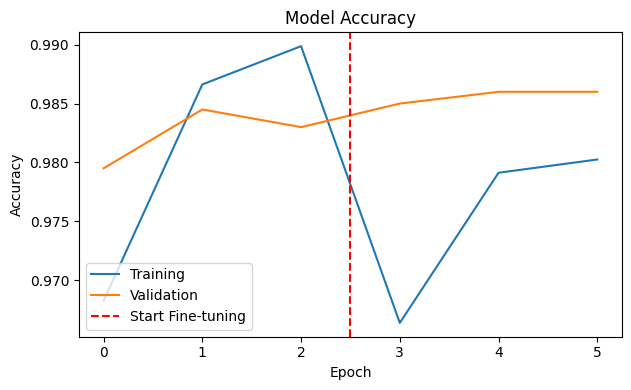

In [5]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)

plt.plot(
    history1.history['accuracy'] + history2.history['accuracy'],
    label='Training'
)
plt.plot(
    history1.history['val_accuracy'] + history2.history['val_accuracy'],
    label='Validation'
)

plt.axvline(x=len(history1.history['accuracy']) - 0.5,
            color='r',
            linestyle='--',
            label='Start Fine-tuning')

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


실사용 시각화

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


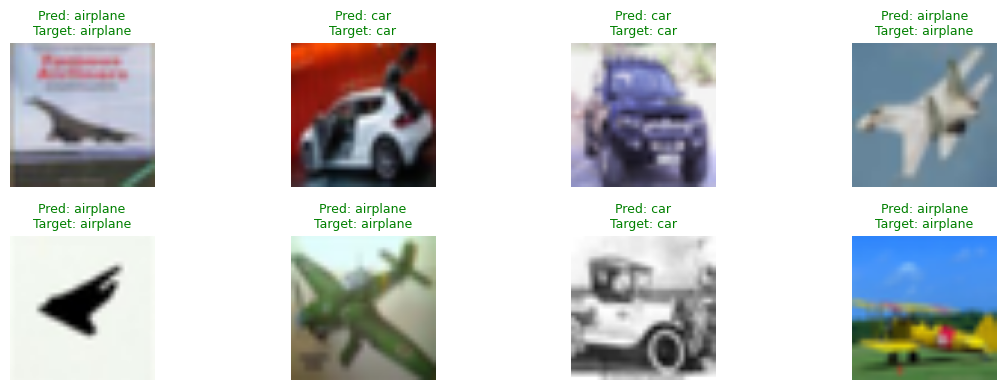

In [6]:
plt.figure(figsize=(12, 4))

predictions = model.predict(x_test[:8])

for i in range(8):
    plt.subplot(2, 4, i + 1)

    img = x_test[i] * 127.5 + 127.5
    plt.imshow(img.numpy().astype('uint8'))

    pred = "car" if predictions[i] > 0.5 else "airplane"
    actual = "car" if y_test[i] == 1 else "airplane"

    color = "green" if pred == actual else "red"

    plt.title(f"Pred: {pred}\nTarget: {actual}", color=color, fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()
